In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [23]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_saluki_pmirGLO_construct.npz")
hl, hl_m = np.mean(save_dict['hl'], axis=-1), save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'leslie_count_pooled'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent-resnet',
    'aparent-resnet+hl',
    'aparent',
    'deerect-apa',
    'polyapred',
]

model_scores = [
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_theano_legacy_30_31_34_pasaligned_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_deerect_apa_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted.npy'),
]

use_saluki = [
    False,
    True,
    False,
    False,
    False,
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))


s.shape = (6944, 10)
m.shape = (6944, 10)
l.shape = (6944, 10)
y.shape = (6944, 10)
c.shape = (6944, 10)

hl.shape = (6944, 10)
hl_m.shape = (6944, 10)
a_rich.shape = (6944, 10)


In [24]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]
hl = hl[:, :max_n_pas]
hl_m = hl_m[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

m_cons = (np.sum(m, axis=-1) == np.sum(hl_m, axis=-1))

has_a_rich = np.zeros(a_rich.shape[0])#np.sum(a_rich, axis=-1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]

m = m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
l = l[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
c = c[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl = hl[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl_m = hl_m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))


m.shape = (5891, 10)
l.shape = (5891, 10)
c.shape = (5891, 10)
y.shape = (5891, 10)
s.shape = (5891, 10)

hl.shape = (5891, 10)
hl_m.shape = (5891, 10)


In [25]:

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


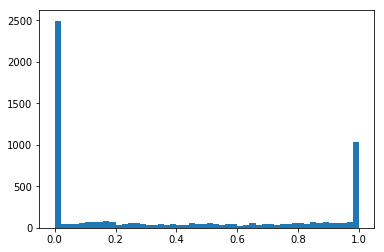

In [26]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist = np.array(y_dist)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [27]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent-resnet'
[ 0.80044966  0.         -0.04937984 -4.8545666   0.94932573  0.
 -0.07230428 -4.29192868]
Spearman r = 0.658
AP = 0.79
n = 5891


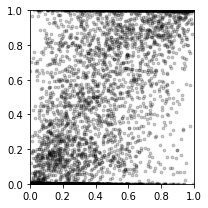

Evaluating model = 'aparent-resnet+hl'
[ 0.76270069 -1.38208789 -0.07403761 -6.26525446  0.92704838 -1.63317017
 -0.12198938 -4.3010642 ]
Spearman r = 0.674
AP = 0.8
n = 5891


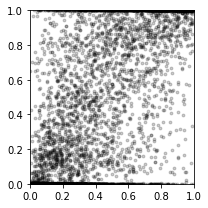

Evaluating model = 'aparent'
[ 0.56644295  0.         -0.04830991 -2.44270756  0.6403416   0.
 -0.09044428 -1.67928469]
Spearman r = 0.591
AP = 0.74
n = 5891


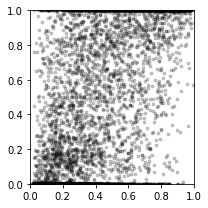

Evaluating model = 'deerect-apa'
[ 3.89006706e-01  0.00000000e+00 -7.13586089e-02 -1.13571403e+01
  7.94963643e-01  0.00000000e+00  8.92570182e-03 -2.87625487e+00]
Spearman r = 0.482
AP = 0.65
n = 5891


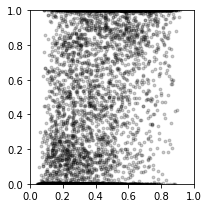

Evaluating model = 'polyapred'
[  0.25981569   0.          -0.07679077 -11.19815148   0.3171955
   0.          -0.03120436 -26.44482574]
Spearman r = 0.419
AP = 0.59
n = 5891


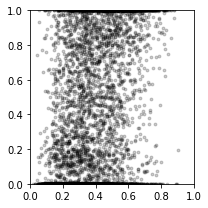

In [28]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + w_prox_hl * hl + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + w_dist_hl * hl + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_hl = w_bundle[1]
    w_prox_len = w_bundle[2]
    w_prox_bias = w_bundle[3]
    w_dist_pas = w_bundle[4]
    w_dist_hl = w_bundle[5]
    w_dist_len = w_bundle[6]
    w_dist_bias = w_bundle[7]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

from sklearn.model_selection import KFold

def cross_val_model(s, hl, m, l, dist_mask, y_true, use_saluki=False, n_folds=10) :
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        s_train, s_test = s[train_index], s[test_index]
        hl_train, hl_test = hl[train_index], hl[test_index]
        m_train, m_test = m[train_index], m[test_index]
        l_train, l_test = l[train_index], l[test_index]
        dist_mask_train, dist_mask_test = dist_mask[train_index], dist_mask[test_index]
        y_true_train = y_true[train_index]
        
        w0 = np.zeros(8)

        res = minimize(logistic_model_mse, w0, args=(s_train, hl_train if use_saluki else 0., m_train, l_train, dist_mask_train, y_true_train), method='BFGS', options={'disp': False})

        w_prox_pas = res.x[0]
        w_prox_hl = res.x[1]
        w_prox_len = res.x[2]
        w_prox_bias = res.x[3]
        w_dist_pas = res.x[4]
        w_dist_hl = res.x[5]
        w_dist_len = res.x[6]
        w_dist_bias = res.x[7]

        if fold_ix == 0 :
            print(res.x)

        y_pred[test_index] = logistic_model_predict(s_test, hl_test if use_saluki else 0., m_test, l_test, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask_test)
    
    return y_pred

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))
model_y_dist_preds = np.zeros((y_dist.shape[0], len(model_scores)))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    y_dist_pred = cross_val_model(s, hl, m, l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap
    model_y_dist_preds[:, model_ix] = y_dist_pred[:]

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [29]:
#Save metrics

np.save("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_aps", model_aps)
np.save("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_y_dist_preds", model_y_dist_preds)
np.save("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_orig_l", orig_l)
np.save("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_hl", hl)
np.save("native_apa_multi_leslie_w_saluki_no_a_rich_filter_cv_20_y_dist", y_dist)
